<div align = "center">
<h1> TIME SERIES MODELING </h1>
<h2> Jaouad Safouani </h2>
</div>

* [A1:RESEARCH QUESTION](#A1)
* [A2:OBJECTIVES AND GOALS](#A2)
* [B:SUMMARY OF ASSUMPTIONS](#B)
* [C1:LINE GRAPH VISUALIZATION](#C1) 
* [C2:TIME STEP FORMATTING](#C2)
* [C3:STATIONARITY](#C3) 
* [C4:STEPS TO PREPARE THE DATA](#C4)
* [C5:PREPARED DATASET](#C5) 
* [D1:REPORT FINDINGS AND VISUALIZATIONS](#D1)
* [D2:ARIMA MODEL](#D2) 
* [D3:FORECASTING USING ARIMA MODEL](#D3)
* [D4:OUTPUT AND CALCULATIONS](#D4) 
* [D5:CODE](#D5) 
* [E1:RESULTS](#E1) 
* [E2:ANNOTATED VISUALIZATION](#E2) 
* [E3:RECOMMENDATIONS](#E3)
* [F:REPORTING](#F)
* [G:SOURCES FOR THIRD-PARTY CODE](#G)
* [H:SOURCES](#H)

<h2> <a id="A1"> A1:RESEARCH QUESTION </a> </h2>

As an analyst at the WGU Telecommunications, I was tasked to analyze the daily revenue from the frist two years of the company operation. The Marketing departement would like to be able to forecast revenue using time series analysis. Can we forecast the revenue from the historical data?

<h2> <a id="A1"> A2:OBJECTIVES AND GOALS  </a> </h2>

The idea is to create a well performing model that can be integrated with an application and would allow the marketing departement to predict the customer revenue, based on previously run marketing campaings. The model will be based on time series modeling. This model will help other departements as well to prepare and manufacture the right quanitities through the year. For example, the supply chain can communicate with cellphone manufacturer and prepare just the right quanity to sell based on revenue predictions. 

<h2> <a id="A1"> B:SUMMARY OF ASSUMPTIONS </a> </h2>

The data is considered non stationary if a strong trend of seasonality is observed from the data. In the other hand, the data is stationary when the mean and the variance do not vary across time (Songhao, 2021). The autocorrelation refers to the degree of similarity between a given time series and a lagged version of itself over a successive time intervals (Anais, 2019).

<h3> Code & Exploratory Analysis </h3>

In [1]:
#importing libraries
import pandas as pd 
# display all columns in the dataframe.
pd.set_option('max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
plt.rc("font", size=14)
%matplotlib inline
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns 
sns.set(style="whitegrid", color_codes=True)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('teleco_time_series .csv', index_col='Day')

In [3]:
df.head()

,Revenue
Day,
1,0.000000
2,0.000793
3,0.825542
4,0.320332
5,1.082554


<h2> <a id="">  Variables </a> </h2>

In [4]:
print(sorted(list(df.columns)))

['Revenue']


In [5]:
df.shape

(731, 1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 731 entries, 1 to 731
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Revenue  731 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


The dataset contains two variables with no missing data.
* Day: Day during first two years of operation
* Revenue: Revenue in million dollars

In [7]:
df.describe()

,Revenue
count,731.000000
mean,9.822901
std,3.852645
min,0.000000
25%,6.872836
50%,10.785571
75%,12.566911
max,18.154769


In [8]:
df.duplicated().sum()

0

<h2> <a id="A1"> C1:LINE GRAPH VISUALIZATION </a> </h2>

In [9]:
def plot_line(df):
    plt.figure(figsize=(14,5))
    plt.plot(df)
    plt.title('Revenue by Day', fontsize = 18, fontweight='bold', color ='#296eaa')
    plt.xlabel('Day',fontweight='bold', color ='#296eaa')
    plt.ylabel('Revenue',fontweight='bold', color ='#296eaa')
    plt.show()

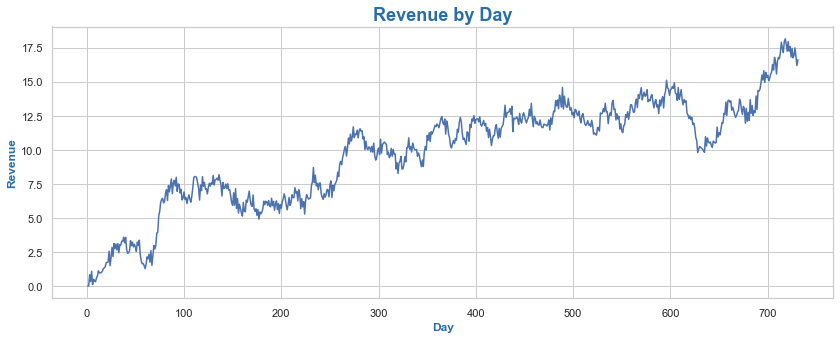

In [10]:
plot_line(df)

<h2> <a id="A1"> C2:TIME STEP FORMATTING </a> </h2>

<h3> <a id=""> Converting the Day Variable into datetime </a> </h3>

In [11]:
try:
    df.index=pd.to_datetime(df.index, unit = 'D', origin = '2019-01-01')
except:
    print('Index was converted to datetime already!')

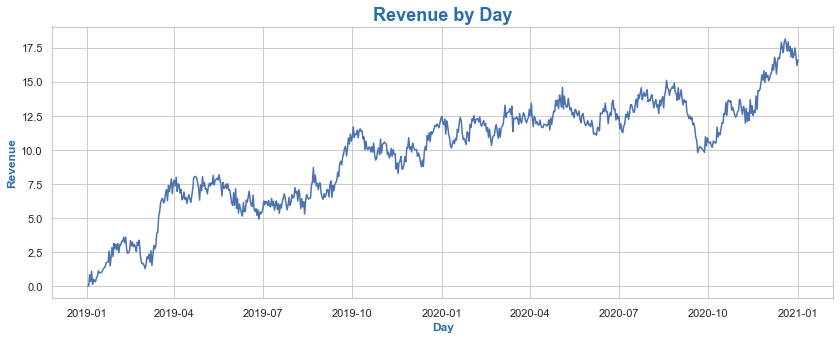

In [12]:
plot_line(df)

There are no gaps in the data.

<h2> <a id="A1"> C3:STATIONARITY </a> </h2>

 <h3> <a id=""> Observations of Dickey-fuller Test </a> </h3>

In [13]:
def dickey_fuller(df):
    df_adf = adfuller(df['Revenue'],autolag='AIC')
    col_list = ['T Statistic','P-value','#Lag','#Observations']
    # df_dict
    df_dict=dict()
    for k, v in zip(col_list, df_adf[0:4]):
        df_dict[k]= v   
    #stats 
    df1 = pd.DataFrame(df_dict, columns = list(df_dict.keys()),index=[0])
    # critical_value
    critical_value = df_adf[4:][0]

    df2 = pd.DataFrame(critical_value, columns = list(critical_value.keys()),index=[0])
    return pd.merge(df1, df2, left_index=True, right_index=True)

In [14]:
dickey_fuller(df)

,T Statistic,P-value,#Lag,#Observations,1%,5%,10%
0,-1.924612,0.320573,1,729,-3.439352,-2.865513,-2.568886


The test statstic is  greater than the critical values 1%, 2% and the 3% with a p-value of 0.32 which is less than the alpha 0.05 therefore there statistal signifanct that the data is non stationary.

<h3> <a id=""> Making the time series data stationary </a> </h3>

In [15]:
df_stationary = df.diff().dropna()

In [16]:
df_stationary.head()

,Revenue
Day,
2019-01-03,0.000793
2019-01-04,0.824749
2019-01-05,-0.505210
2019-01-06,0.762222
2019-01-07,-0.974900


In [17]:
rolmean = df_stationary.rolling(7).mean()
rolstd = df_stationary.rolling(7).std()

<h3> <a id=""> Ploting stationary data vs moving 7 days average vs moving 7 days std </a> </h3>

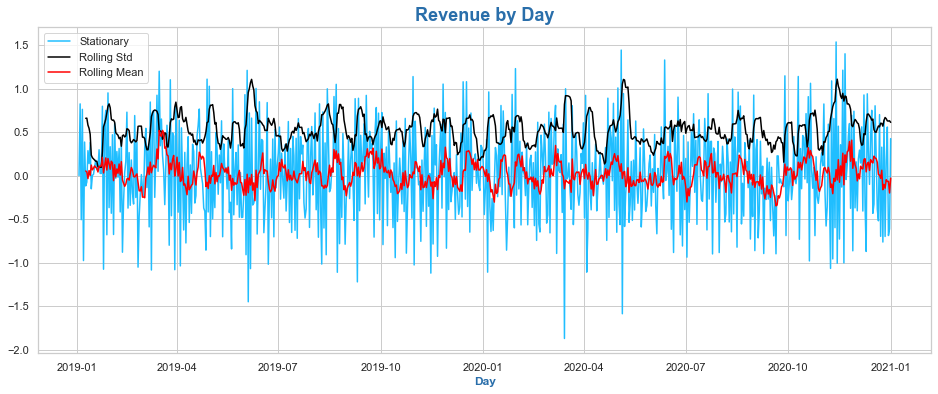

In [18]:
plt.figure(figsize=(16,6))
plt.plot(df_stationary, color='#20beff',label='Stationary')
plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.title('Revenue by Day', fontsize = 18, fontweight='bold', color ='#296eaa')
plt.xlabel('Day',fontweight='bold', color ='#296eaa')
plt.legend()
plt.show()

 <h3> <a id=""> df_stationary observations of Dickey-fuller Test </a> </h3>

In [19]:
dickey_fuller(df_stationary)

,T Statistic,P-value,#Lag,#Observations,1%,5%,10%
0,-44.874527,0.0,0,729,-3.439352,-2.865513,-2.568886


The test statstic is -44.87 which is less than the critical values 1%, 2% and the 3% with a p-value of 0.0 which is less than the alpha 0.05 therefore there statistal signifanct that the data is now stationary.

<h2> <a id="A1"> C4:STEPS TO PREPARE THE DATA </a> </h2>

In [20]:
df_stationary.isnull().sum()

Revenue    0
dtype: int64

There are no missing values in the dataset.

In [21]:
df_stationary.duplicated().sum()

0

df_stationary has no duplicates

<h2> <a id="A1"> C5:PREPARED DATASET </a> </h2>

In [22]:
df_stationary.to_csv('prepared_dataset.csv')

<h2> <a id="A1"> D1:REPORT FINDINGS AND VISUALIZATIONS </a> </h2>

In [23]:
decompose=seasonal_decompose(df_stationary['Revenue'],  model='additive', period=1)

In [24]:
seasonal = decompose.seasonal
trend=decompose.trend
resid=decompose.resid
observed=decompose.observed

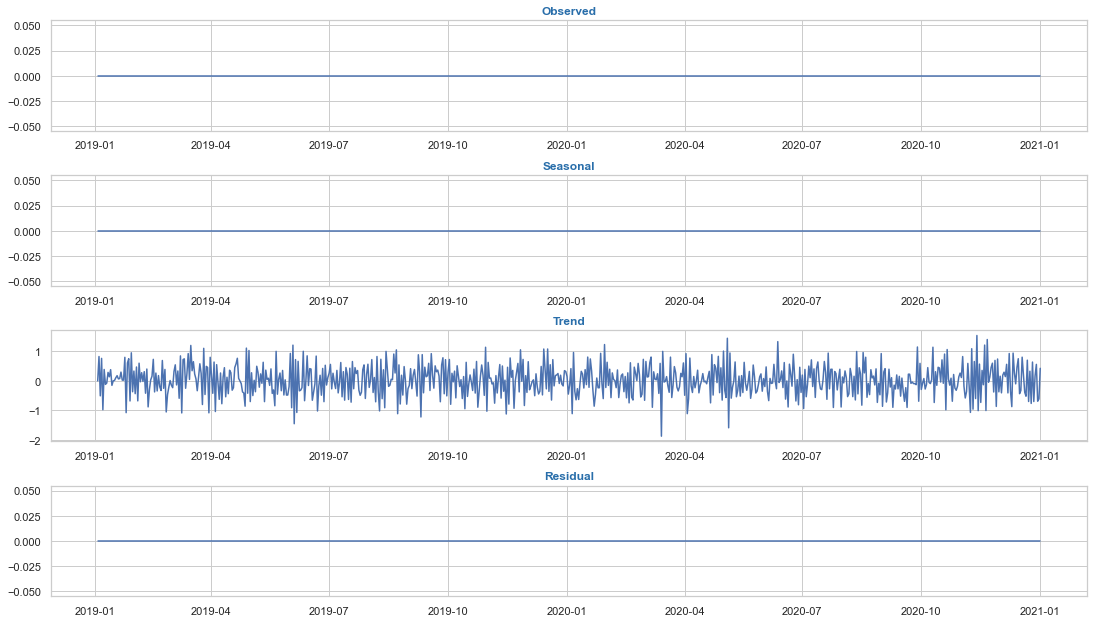

In [25]:
plt.figure(figsize=(18,10))
fig=plt.figure(1)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)


plt.subplot(411)
plt.plot(seasonal, label='observed')
plt.title('Observed', fontweight='bold', color ='#296eaa')

plt.subplot(412)
plt.plot(seasonal, label='seasonal')
plt.title('Seasonal', fontweight='bold', color ='#296eaa')

plt.subplot(413)
plt.plot(trend, label='trend')
plt.title('Trend', fontweight='bold', color ='#296eaa')

plt.subplot(414)
plt.plot(resid, label='resid')
plt.title('Residual', fontweight='bold', color ='#296eaa')

plt.show()

We can confirm that the data there is no Trend in the data.

<h2> <a id="A1"> D2:ARIMA MODEL </a> </h2>

<h3> <a id=""> Autocorrelation and Partial Autocorrelation Plots </a> </h3>

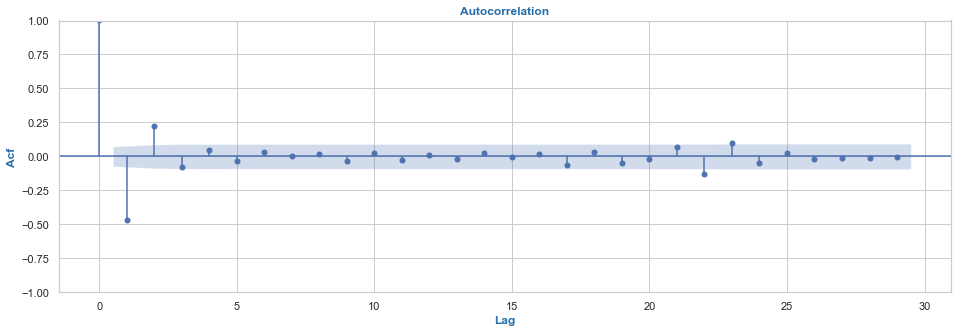

In [26]:
fig = plot_acf(df_stationary)
fig.set_size_inches(16, 5)
plt.title('Autocorrelation',fontweight='bold', color ='#296eaa')
plt.xlabel('Lag',fontweight='bold', color ='#296eaa')
plt.ylabel('Acf',fontweight='bold', color ='#296eaa')
plt.show(fig)

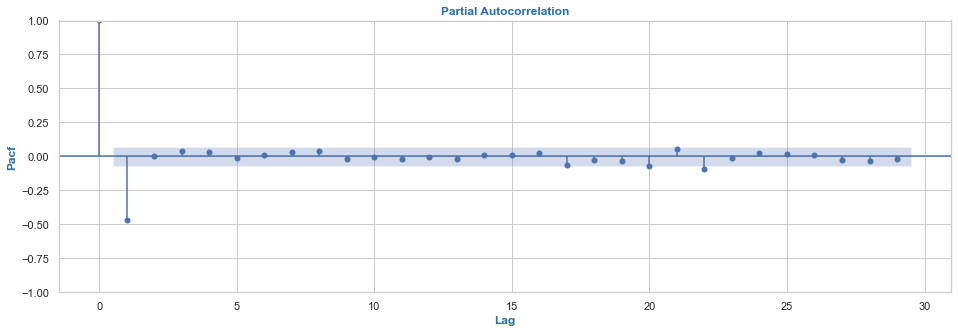

In [27]:
fig = plot_pacf(df_stationary)
fig.set_size_inches(16, 5)
plt.title('Partial Autocorrelation',fontweight='bold', color ='#296eaa')
plt.xlabel('Lag',fontweight='bold', color ='#296eaa')
plt.ylabel('Pacf',fontweight='bold', color ='#296eaa')
plt.show(fig)

Let's identify p, d and q parameters for the <b> ARIMA(p,d,q) </b>.
From the Autocorraltion and the partial correlation graphs we can clearly tell that the there are 5 lags that ar eoutside of the shaded areas therefore <b>p-value = 5</b>.The data is stationary with a difference of 1 lag; therefore, d=1. Finally, the data is stationary; therefore, the q=0.

<h3> <a id=""> Fitting the ARIMA Model </a> </h3>

In [28]:
try:
    df_stationary.index = df_stationary.index.to_period('D')
except:
    pass

model = ARIMA(df_stationary, order=(5,1,0), freq = "D")
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  730
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -545.622
Date:                Mon, 09 May 2022   AIC                           1103.243
Time:                        20:42:08   BIC                           1130.793
Sample:                    01-03-2019   HQIC                          1113.873
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2947      0.036    -35.703      0.000      -1.366      -1.224
ar.L2         -1.0175      0.057    -17.802      0.000      -1.130      -0.906
ar.L3         -0.7079      0.065    -10.935      0.0

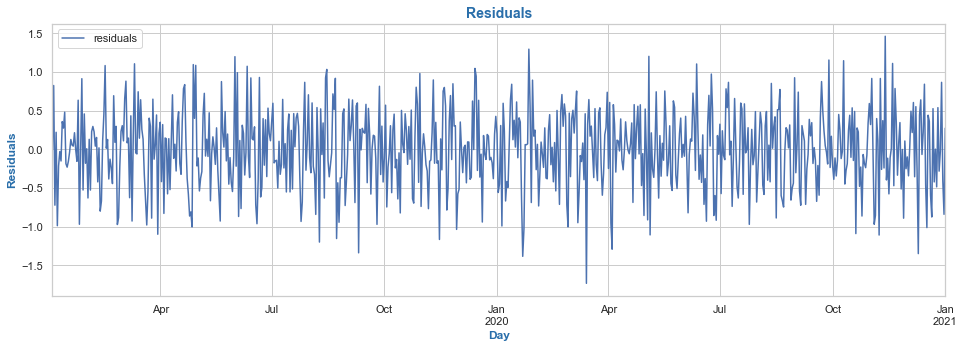

In [29]:
# Plotting residual in Line Plot
resid = pd.DataFrame(model_fit.resid, columns=['residuals'])
resid.plot(figsize=(16,5))
plt.title('Residuals', fontsize = 14, fontweight='bold', color ='#296eaa')
plt.xlabel('Day',fontweight='bold', color ='#296eaa')
plt.ylabel('Residuals',fontweight='bold', color ='#296eaa')
plt.show()

<h3> <a id=""> Kde plot and histplot </a> </h3>

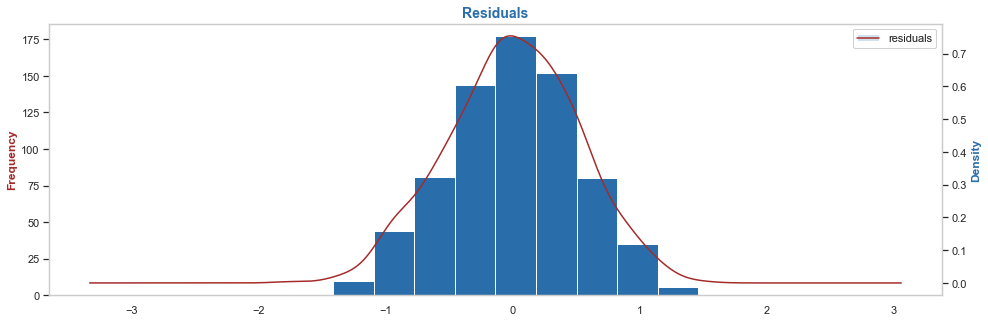

In [30]:
fig, ax1 = plt.subplots(1, 1, figsize=(16,5))
resid.plot(kind='hist', ax=ax1,color ='#296eaa')
plt.ylabel('Frequency',fontweight='bold', color ='brown')
ax1.grid(False)
ax2 = ax1.twinx()
resid.plot(kind='kde', ax=ax2, color='brown')
plt.title('Residuals', fontsize = 14, fontweight='bold', color ='#296eaa')
plt.ylabel('Density',fontweight='bold', color ='#296eaa')
ax2.grid(False)
plt.show()

<h2> <a id="A1"> D3:FORECASTING USING ARIMA MODEL </a> </h2>

In [31]:
X_train = df_stationary.values
train_len = round(len(X_train) * 0.70)
train = X_train[0:train_len]
test  =  X_train[train_len:len(X_train)]
test_ = [x[0] for x in test]
start_index =  len(train)
end_index = len(train) + len(test_)-1
pred = model_fit.predict(start = start_index, end = end_index)

In [32]:
test_vs_pred = pd.DataFrame(zip(test_,pred ), columns =['Test', 'Forecast'])              
test_vs_pred['Difference'] = test_vs_pred['Test'] - test_vs_pred['Forecast']
test_vs_pred

,Test,Forecast,Difference
0,-0.126817,0.007426,-0.134243
1,0.137300,-0.064324,0.201624
2,0.237650,-0.165391,0.403042
3,-0.348350,-0.243331,-0.105019
4,0.079178,0.015976,0.063202
...,...,...,...
214,0.170280,0.194469,-0.024189
215,0.559108,-0.305936,0.865044
216,-0.687028,-0.282486,-0.404542
217,-0.608824,0.232690,-0.841514


<h2> <a id="A1"> D4:OUTPUT AND CALCULATIONS </a> </h2>

 <h3> <a id=""> mean_squared_error </a> </h3>

In [33]:
mse_ = mean_squared_error(test, pred)
print('MSE: %.3f' % mse_)

MSE: 0.261


Please see above for more calculations.

<h2> <a id="A1"> D5:CODE </a> </h2>

Please see above previous sections

<h2> <a id="A1"> E1:RESULTS </a> </h2>

The dataset has no seasonal variance therefore we used ARIMA. The MSE = 0.264 explains the performance of the non seasonal ARIMA (5,1,0) model. Using the Pact and acf we were able to predict the p-value =5. 

<h2> <a id="A1"> E2:ANNOTATED VISUALIZATION </a> </h2>

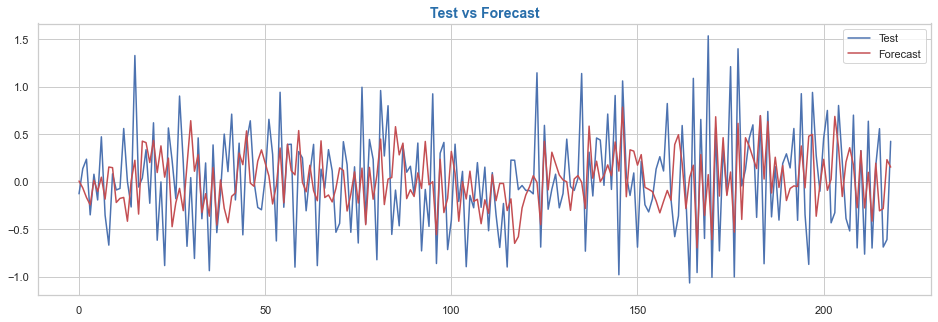

In [34]:
# plot forecasts against actual outcomes
plt.figure(figsize=(16,5))
plt.title('Test vs Forecast', fontsize = 14, fontweight='bold', color ='#296eaa')
plt.plot(test_vs_pred.Test, label='Test', color ='b')
plt.plot(test_vs_pred.Forecast, label ='Forecast', color='r')
plt.xlabel('')
plt.legend()
plt.show()

<h2> <a id="A1"> E3:RECOMMENDATIONS </a> </h2>

The size of the dataset is small, if the dataset was bugger than we would probably have a better predictions and a lower mean squared error. In the other hand, WGU Telecommuncations can know take data driven decision based on forecasted revenue. For example, the company can use predicted revenue as an indication to do more analysis such as analyzing phone inventories and ordering enough phone units to meet the customer needs.

<h2> <a id="A1"> F:REPORTING </a> </h2>

Please attached PDF and This Jupyter Notebook

<h2> <a id="A1"> G:SOURCES FOR THIRD-PARTY CODE </a> </h2>

Stock Overflow. 2/16/2018.<https://stackoverflow.com/questions/45596492/statsmodels-arima-different-results-using-predict-and-forecast>

<h2> <a id="A1"> H:SOURCES </a> </h2>

Anais, Songhao. Stationarity Assumption in Time Series Data. 7/5/2021. <https://towardsdatascience.com/stationarity-assumption-in-time-series-data-67ec93d0f2f>

Wu, Dotis-Georgiou. Autocorrelation in Time Series Data. 7/5/2021. <https://www.influxdata.com/blog/autocorrelation-in-time-series-data/>